In [1]:
import numpy as np
import pandas as pd

from pywarper.surface import fit_surface, warp_surface
from pywarper.arbor import warp_arbor, get_zprofile
from pywarper.utils import read_arbor_trace

In [2]:
def read_ChAT(filename):
    
    df = pd.read_csv(filename, comment='#', sep=r'\s+')
    x = df["X"].values.astype(float)
    y = df["Slice"].values.astype(float)
    z = df["Y"].values.astype(float)

    x = x + 1
    z = z + 1

    return x, y ,z

# data from Sümbül et al. 2014
# https://github.com/uygarsumbul/rgc
chat_top = read_ChAT("../tests/data/Image013-009_01_ChAT-TopBand-Mike.txt") # should be the off sac layer
chat_bottom = read_ChAT("../tests/data/Image013-009_01_ChAT-BottomBand-Mike.txt") # should be the on sac layer
# but the image can be flipped
if chat_top[2].mean() > chat_bottom[2].mean():
    off_sac = chat_top
    on_sac = chat_bottom
else:
    off_sac = chat_bottom
    on_sac = chat_top

rgc, nodes, edges, radii = read_arbor_trace("../tests/data/Image013-009_01_raw_latest_Uygar.swc")
nodes += 1 # to match the matlab code

In [3]:
# Fit surfaces with pygridfit under the hood
thisvzmaxmesh, xgridmax, ygridmax = fit_surface(x=off_sac[0], y=off_sac[1], z=off_sac[2], smoothness=15)
thisvzminmesh, xgridmin, ygridmin = fit_surface(x=on_sac[0], y=on_sac[1], z=on_sac[2], smoothness=15)

In [4]:
# fit quasi-conformally mapping
arbor_boundaries = np.array([nodes[:, 0].min(), nodes[:, 0].max(), nodes[:, 1].min(), nodes[:, 1].max()])
surface_mapping = warp_surface(thisvzminmesh, thisvzmaxmesh, arbor_boundaries, conformal_jump=2, verbose=True)

Warping surface...
Mapping min position (On SAC layer)...
Mapping min position completed in 3.73 seconds.
Mapping max position (Off SAC layer)...
Mapping max position completed in 3.76 seconds.


In [5]:
# warp the arbor
warped_arbor = warp_arbor(nodes, edges, radii, surface_mapping, voxel_resolution=[0.4, 0.4, 0.5], conformal_jump=2, verbose=True)
warped_nodes = warped_arbor["nodes"]

# save as swc
# warped_arbor_arr = np.hstack([
#     warped_arbor["edges"][:, 0][:, None].astype(int),  # 1
#     np.zeros_like(warped_arbor["edges"][:, 1][:, None]),  # 2
#     warped_arbor["nodes"],  # 3, 4, 5
#     warped_arbor["radii"][:, None], # 6
#     warped_arbor["edges"][:, 1][:, None]]) # 7
# df_warped_arbor = pd.DataFrame(warped_arbor_arr, columns=["n", "t", "x", "y", "z", "radius", "parent"])
# df_warped_arbor.to_csv("warped_arbor.swc", sep="\t", index=False, header=False)

Warping nodes...
Nodes warped in 3.91 seconds.


In [6]:
# basically the same as the tests
import scipy.io
warped_arbor_mat = scipy.io.loadmat("../tests/data/warpedArbor_jump.mat", squeeze_me=True, struct_as_record=False)["warpedArbor"]
warped_arbor_mat = {
    "nodes": warped_arbor_mat.nodes,
    "edges": warped_arbor_mat.edges,
    "radii": warped_arbor_mat.radii,
    "medVZmin": warped_arbor_mat.medVZmin,
    "medVZmax": warped_arbor_mat.medVZmax
}

np.allclose(warped_nodes, warped_arbor_mat["nodes"]),\
np.isclose(warped_arbor["medVZmin"], warped_arbor_mat["medVZmin"]),\
np.isclose(warped_arbor["medVZmax"], warped_arbor_mat["medVZmax"])

(True, np.True_, np.True_)

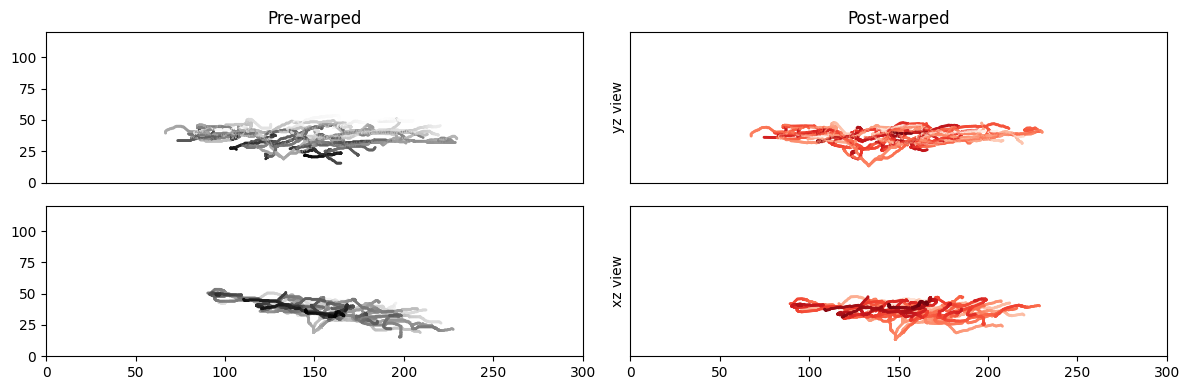

In [7]:
import matplotlib.pyplot as plt
mosaic = """
AB
CD
"""
fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(12, 4))

depth_order_pre = np.argsort(nodes[:, 1])  # ascending (far → near)
sorted_nodes_pre = nodes[depth_order_pre] * [0.4, 0.4, 0.5]  # scale to match the warped nodes

# Sort nodes for post-warped plot by depth (y-axis)
depth_order_post = np.argsort(warped_nodes[:, 1])
sorted_nodes_post = warped_nodes[depth_order_post]

# pre-warped
ax["A"].scatter(sorted_nodes_pre[:, 1], sorted_nodes_pre[:, 2], c=sorted_nodes_pre[:, 0], s=1, alpha=1, cmap="Grays")
ax["C"].scatter(sorted_nodes_pre[:, 0], sorted_nodes_pre[:, 2], c=sorted_nodes_pre[:, 1], s=1, alpha=1, cmap="Grays")
ax["A"].set_title("Pre-warped")

# post-warped
ax["B"].scatter(sorted_nodes_post[:, 1], sorted_nodes_post[:, 2], c=sorted_nodes_post[:, 0], s=1, alpha=1, cmap="Reds")
ax["D"].scatter(sorted_nodes_post[:, 0], sorted_nodes_post[:, 2], c=sorted_nodes_post[:, 1], s=1, alpha=1, cmap="Reds")

ax["B"].set_ylabel("yz view")
ax["D"].set_ylabel("xz view")

ax["B"].set_title("Post-warped")

for i in ["A", "B", "C", "D"]:

    if i not in ['C', 'D']:
        ax[i].set_xticks([])

    if i not in ['A', 'C']:
        ax[i].set_yticks([])

    ax[i].set_ylim(0, 120)
    ax[i].set_xlim(0, 300)

fig.tight_layout()

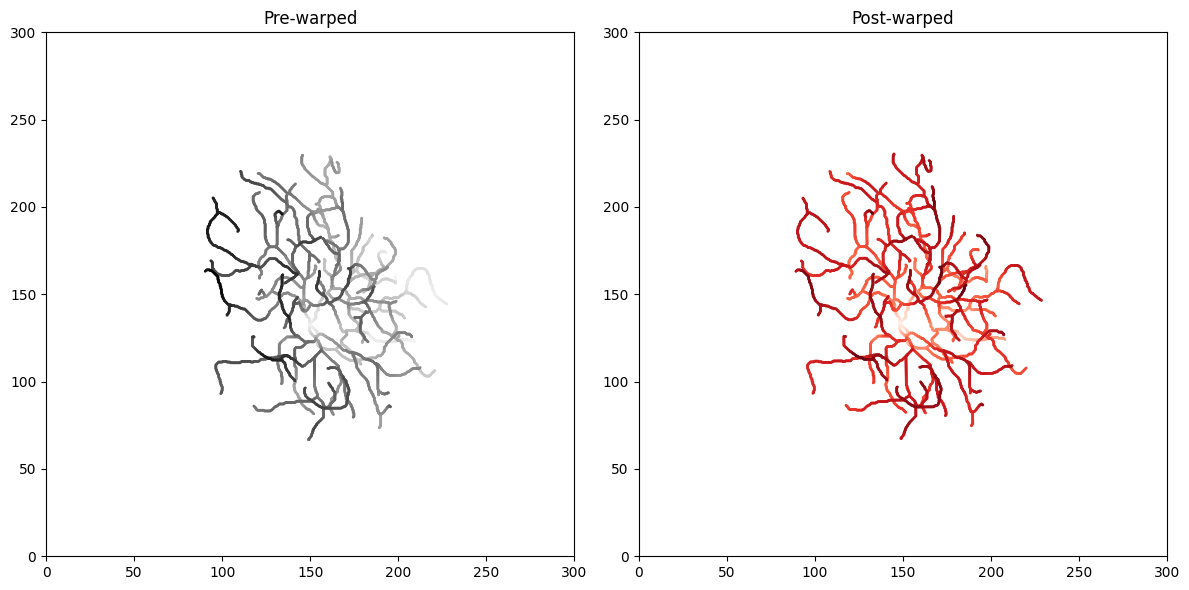

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2, figsize=(12, 6))

depth_order_pre = np.argsort(nodes[:, 2])  # ascending (far → near)
sorted_nodes_pre = nodes[depth_order_pre] * [0.4, 0.4, 0.5]  # scale to match the warped nodes

# Sort nodes for post-warped plot by depth (y-axis)
depth_order_post = np.argsort(warped_nodes[:, 2])
sorted_nodes_post = warped_nodes[depth_order_post]


ax[0].scatter(sorted_nodes_pre[:, 0], sorted_nodes_pre[:, 1], c=sorted_nodes_pre[:, 2], s=1, alpha=1, cmap="Grays")
ax[1].scatter(sorted_nodes_post[:, 0], sorted_nodes_post[:, 1], c=sorted_nodes_post[:, 2], s=1, alpha=1, cmap="Reds")

ax[0].set_title("Pre-warped")
ax[1].set_title("Post-warped")
for i in range(2):
    ax[i].set_ylim(0, 300)
    ax[i].set_xlim(0, 300)

fig.tight_layout()

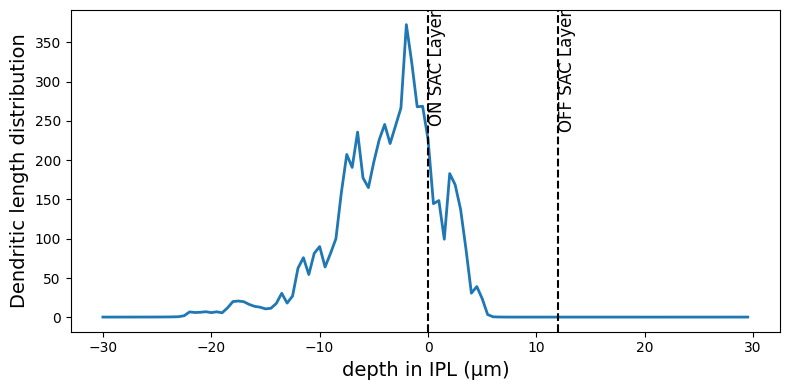

In [9]:
x, z = get_zprofile(warped_arbor, z_res=0.5, grid_point_count=120, z_ext=5.)

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(x, z, lw=2)
ax.axvline(0,  color='k', ls='--')
ax.axvline(12, color='k', ls='--')
y_top = ax.get_ylim()[1]                            
ax.text( 0,  y_top, 'ON SAC Layer',
        rotation=90, va='top', ha='left',
        fontsize=12, bbox=dict(boxstyle='round,pad=0.2', fc='none', ec='none'))

ax.text(12, y_top, 'OFF SAC Layer',
        rotation=90, va='top', ha='left',
        fontsize=12, bbox=dict(boxstyle='round,pad=0.2', fc='none', ec='none'))

ax.set_ylabel('Dendritic length distribution', fontsize=14)
ax.set_xlabel('depth in IPL (μm)', fontsize=14)

fig.tight_layout()


In [10]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark

Last updated: 2025-04-24 16:30:10CEST

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.1.0

pandas    : 2.2.3
pywarper  : 0.1.1
scipy     : 1.15.2
matplotlib: 3.10.1
numpy     : 2.2.5

Watermark: 2.5.0

